In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load data

In [2]:
# filename = 'Datasets/final_imit_spec.pkl'
# filename = 'Datasets/final_imit_spec2_128.pkl'
filename = 'Datasets/final_imit_spec2_128_last.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(800, 120, 128, 128, 3)
(200, 120, 128, 128, 3)
(800, 120, 19)
(200, 120, 19)
(800,)
(200,)


In [3]:
# filename = 'Datasets/final_native_spec.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# native_train_images, native_test_images, native_y_train, native_y_test, native_env_train, native_env_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(len(native_train_images))
# print(len(native_test_images))
# print(native_y_train.shape)
# print(native_y_test.shape)
# print(native_env_train.shape)
# print(native_env_test.shape)

##### STA LTA

In [4]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [5]:
duration = 24.2
nsta_sec = 0.7
ratio = imit_env_train[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,imit_env_train[0].shape[-1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(imit_env_train)):
    vecs_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(imit_env_test)):
    vecs_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

### Visualize

In [6]:
# idx = 3
# plt.plot(timevec,imit_env_test[idx]/max(imit_env_test[idx]),color='black')
# plt.plot(timevec,mask_test[idx],linewidth=3,color='red')
# plt.legend(['Euclidean Distance','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
# fig = plt.gcf()
# fig.set_size_inches(12,6)
# plt.xticks(fontsize=19)
# plt.yticks(fontsize=19)
# plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
# plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# # plt.savefig(str(idx)+' gesture detect.png',dpi=400)

In [7]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [8]:
numgest = [gesture_counter(m) for m in mask_test]
sum(numgest)

1291

In [9]:
num_class = 19

In [10]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [11]:
def down_mask(mask, des_len):
    return np.array([mask[int(len(mask)/des_len*i)] for i in range(des_len)])

In [12]:
des_len = imit_train_images.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test])
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(800, 120)
(200, 120)
(800, 120, 19)
(200, 120, 19)
(800, 120, 19, 19)
(200, 120, 19, 19)


In [13]:
x3train, y3train = masker(imit_train_images, np.argmax(y_down_train,-1), mask_down_train)
x3test, y3test = masker(imit_test_images, np.argmax(y_down_test,-1), mask_down_test) 
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(4735,)
(4735,)
(1190,)
(1190,)


In [14]:
y3train[0].shape

(16, 19)

In [15]:
classes = [stats.mode(np.argmax(y,-1))[0] for y in y3train]
c = [int(x) for x in classes]
Counter(c)

Counter({1: 1061,
         10: 168,
         11: 156,
         12: 148,
         3: 789,
         2: 455,
         4: 163,
         0: 92,
         16: 165,
         17: 166,
         18: 172,
         7: 147,
         8: 159,
         9: 152,
         5: 154,
         6: 140,
         13: 143,
         14: 145,
         15: 160})

In [16]:
# eliminate zeros md
x6train = np.array([x3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y6train = np.array([y3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x6test = np.array([x3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y6test = np.array([y3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x6train.shape)
print(y6train.shape)
print(x6test.shape)
print(y6test.shape)

(4643,)
(4643,)
(1164,)
(1164,)


## RD - RA

In [17]:
# filename = 'Datasets/final_imit_RD-RA2.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# imit_y_train_RD, imit_y_test_RD, imit_RD_train, imit_RA_train, imit_RD_test, imit_RA_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(imit_y_train_RD.shape)
# print(imit_y_test_RD.shape)
# print(imit_RD_train.shape)
# print(imit_RA_train.shape)
# print(imit_RD_test.shape)
# print(imit_RA_test.shape)
# del x

In [18]:
filename = 'Datasets/final_imit_RD-RA2_128_last.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
imit_RD_train = np.array(data["train_RD"])
imit_RA_train = np.array(data["train_RA"])
imit_RD_test = np.array(data["test_RD"])
imit_RA_test = np.array(data["test_RA"])
data.close()
print(imit_RD_train.shape)
print(imit_RA_train.shape)
print(imit_RD_test.shape)
print(imit_RA_test.shape)

Selected File: Datasets/final_imit_RD-RA2_128_last.hdf5
(800, 605, 128, 128, 3)
(800, 605, 128, 128, 3)
(200, 605, 128, 128, 3)
(200, 605, 128, 128, 3)


In [19]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(imit_RD_train[:,interval,:,:,:], (imit_RD_train.shape[0],120,5,imit_RD_train.shape[2],imit_RD_train.shape[3],imit_RD_train.shape[4]))
x_test11 = np.reshape(imit_RD_test[:,interval,:,:,:], (imit_RD_test.shape[0],120,5,imit_RD_test.shape[2],imit_RD_test.shape[3],imit_RD_test.shape[4]))
# y_train11 = np.reshape(imit_y_train_RD[:,interval], (imit_y_train_RD.shape[0],120,5))
# y_test11 = np.reshape(imit_y_test_RD[:,interval], (imit_y_test_RD.shape[0],120,5))
# y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
# y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
# print(y_train11.shape)
print(x_test11.shape)
# print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(imit_RA_train[:,interval,:,:,:], (imit_RA_train.shape[0],120,5,imit_RA_train.shape[2],imit_RA_train.shape[3],imit_RA_train.shape[4]))
x_test12 = np.reshape(imit_RA_test[:,interval,:,:,:], (imit_RA_test.shape[0],120,5,imit_RA_test.shape[2],imit_RA_test.shape[3],imit_RA_test.shape[4]))
print(x_train12.shape)
print(x_test12.shape)

(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)
(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)


In [20]:
# x1train, y1train = masker(x_train11, np.argmax(y_train11,-1), mask_down_train)
# x1test, y1test = masker(x_test11, np.argmax(y_test11,-1), mask_down_test)
# x2train, y1train = masker(x_train12, np.argmax(y_train11,-1), mask_down_train)
# x2test, y1test = masker(x_test12, np.argmax(y_test11,-1), mask_down_test)
x1train, y1train = masker(x_train11, y_down_train, mask_down_train)
x1test, y1test = masker(x_test11, y_down_test, mask_down_test)
x2train, y1train = masker(x_train12, y_down_train, mask_down_train)
x2test, y1test = masker(x_test12, y_down_test, mask_down_test)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(x2test.shape)

(4735,)
(4735,)
(1190,)
(1190,)
(4735,)
(1190,)


In [21]:
x10train = np.array([x1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x11train = np.array([x2train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
# y10train = np.array([y1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x10test = np.array([x1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
x11test = np.array([x2test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
# y10test = np.array([y1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x10train.shape)
# print(y10train.shape)
print(x10test.shape)
# print(y10test.shape)
print(x11train.shape)
print(x11test.shape)

(4643,)
(1164,)
(4643,)
(1164,)


In [22]:
x12train = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x10train])
x13train = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x11train])
x12test = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x10test])
x13test = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x11test])
print(x12train[0].shape)
print(x12test[0].shape)
print(x13train.shape)
print(x13test.shape)

(80, 128, 128, 3)
(95, 128, 128, 3)
(4643,)
(1164,)


In [23]:
input_shape_vid = (None, x_train11[0].shape[1],x_train11[0].shape[2],x_train11[0].shape[3],x_train11[0].shape[4])
print('Input shape of f-b-f RD: ',input_shape_vid)

Input shape of f-b-f RD:  (None, 5, 128, 128, 3)


In [24]:
input_shape11 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
print('Input shape of f-b-f mD: ',input_shape11)

Input shape of f-b-f mD:  (None, 128, 128, 3)


In [25]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)

In [26]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=0, verbose=0)

In [27]:
gc.collect()

149

In [28]:
ytrain = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3train[i],-1))[0],19)) for i in tqdm(range(len(y3train)), position = 0, leave = True) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
ytest = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3test[i],-1))[0],19)) for i in tqdm(range(len(y3test)), position = 0, leave = True) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(ytrain.shape)
print(ytest.shape)

100%|██████████| 1190/1190 [00:00<00:00, 2815.51it/s]

(4643, 19)
(1164, 19)


In [29]:
def mode_finder(y): # finds the mode that is not zero
    y = np.argmax(y,-1)
    mode = stats.mode(y)[0]
    if mode == 0:
        mask = y == mode
        y = y[~np.ma.masked_array(y, mask = mask).mask]
        new_mode = stats.mode(y)[0]
    else:
        new_mode = mode
    return np.squeeze(new_mode)

In [30]:
# # convert zeros to 2nd mode
# y3train2 = np.array([to_categorical(mode_finder(y),19) for y in y3train])
# y3test2 = np.array([to_categorical(mode_finder(y),19) for y in y3test])
# # remove fully zeros
# lens_tr = [len(y) for y in y3train2]
# lens_ts = [len(y) for y in y3test2]
# mask_tr = np.array(lens_tr) == 0
# mask_ts = np.array(lens_ts) == 0
# print('In total ' +str(np.sum(mask_tr)) + ' fully zeros out of ' + str(len(mask_tr)) + ' found and eliminated (training)')
# print('In total ' +str(np.sum(mask_ts)) + ' fully zeros out of ' + str(len(mask_ts)) + ' found and eliminated (testing)')
# y3train2 = y3train2[~np.ma.masked_array(y3train2, mask = mask_tr).mask]
# y3test2 = y3test2[~np.ma.masked_array(y3test2, mask = mask_ts).mask]
# x6train2 = x3train[~np.ma.masked_array(x3train, mask = mask_tr).mask]
# x6test2 = x3test[~np.ma.masked_array(x3test, mask = mask_ts).mask]
# x10train2 = x1train[~np.ma.masked_array(x1train, mask = mask_tr).mask]
# x10test2 = x1test[~np.ma.masked_array(x1test, mask = mask_ts).mask]
# x11train2 = x2train[~np.ma.masked_array(x2train, mask = mask_tr).mask]
# x11test2 = x2test[~np.ma.masked_array(x2test, mask = mask_ts).mask]

# y3train2 = np.array([y for y in y3train2])
# y3test2 = np.array([y for y in y3test2])

In [31]:
# print(y3train2.shape)
# print(y3test2.shape)
# print(x6train2.shape)
# print(x6test2.shape)
# print(x10train2.shape)
# print(x10test2.shape)
# print(x11train2.shape)
# print(x11test2.shape)
# print(Counter(np.argmax(y3train2,-1)))
# print(Counter(np.argmax(y3test2,-1)))

## t-SNE sifting

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

In [42]:
tsneX = np.array([np.resize(x, (128*128)) for x in tqdm(x12train)])
tsneY = np.argmax(ytrain,-1)
print(tsneX.shape)
print(tsneY.shape)

tsneout = TSNE(n_components = 3,random_state=1).fit_transform(tsneX)

100%|██████████| 4368/4368 [00:08<00:00, 497.71it/s]


(4368, 16384)
(4368,)


In [43]:
hull = Delaunay(tsneout) 

In [44]:
def plot_generator():
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111,projection='3d') 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_zlabel('Principal Component 3', fontsize = 15)
    ax.set_title('3 component t-SNE', fontsize = 20)
    ax.grid()
    return fig, ax

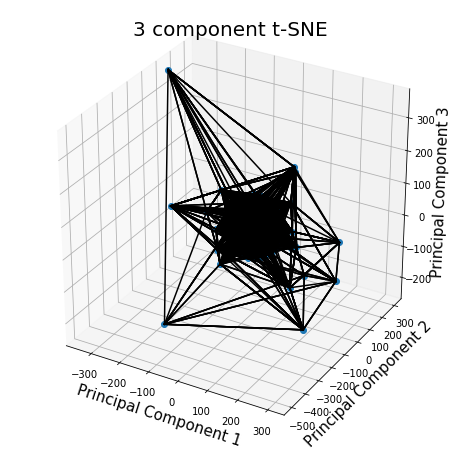

<Figure size 432x288 with 0 Axes>

In [46]:
fig, ax = plot_generator()
ax.plot(tsneout[:,0], tsneout[:,1],tsneout[:,2], 'o')
for simplex in hull.simplices:
    ax.plot(tsneout[simplex, 0], tsneout[simplex, 1],tsneout[simplex, 2], 'k-')
plt.show() 
plt.savefig('t-SNE convex haull for class Walk')

In [47]:
tsneX = np.array([np.resize(x, (128*128)) for x in tqdm(x6train)])
tsneY = np.argmax(ytrain,-1)
print(tsneX.shape)
print(tsneY.shape)

tsneout = TSNE(n_components = 3,random_state=1).fit_transform(tsneX)

100%|██████████| 4368/4368 [00:26<00:00, 165.31it/s]


(4368, 16384)
(4368,)


In [48]:
hull = Delaunay(tsneout) 

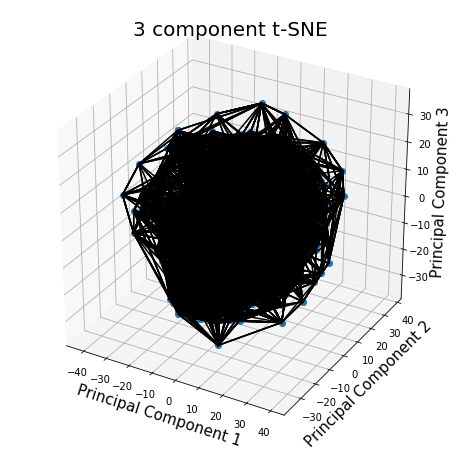

<Figure size 432x288 with 0 Axes>

In [49]:
fig, ax = plot_generator()
ax.plot(tsneout[:,0], tsneout[:,1],tsneout[:,2], 'o')
for simplex in hull.simplices:
    ax.plot(tsneout[simplex, 0], tsneout[simplex, 1],tsneout[simplex, 2], 'k-')
plt.show() 
plt.savefig('t-SNE convex haull for class Walk')

In [50]:
tsneX = np.array([np.resize(x, (128*128)) for x in tqdm(x13train)])
tsneY = np.argmax(ytrain,-1)
print(tsneX.shape)
print(tsneY.shape)

tsneout = TSNE(n_components = 3,random_state=1).fit_transform(tsneX)

100%|██████████| 4368/4368 [00:09<00:00, 463.02it/s]


(4368, 16384)
(4368,)


In [51]:
hull = Delaunay(tsneout) 

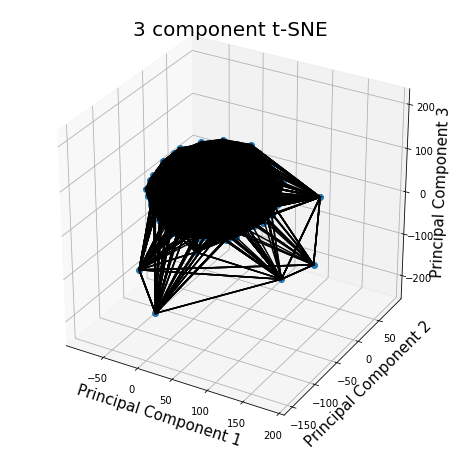

<Figure size 432x288 with 0 Axes>

In [52]:
fig, ax = plot_generator()
ax.plot(tsneout[:,0], tsneout[:,1],tsneout[:,2], 'o')
for simplex in hull.simplices:
    ax.plot(tsneout[simplex, 0], tsneout[simplex, 1],tsneout[simplex, 2], 'k-')
plt.show() 
plt.savefig('t-SNE convex haull for class Walk')

In [31]:
lens = [len(y) for y in y6train]
print(max(lens))
print(min(lens))

52
3


# Gesture detector accuracy

In [44]:
print(mask_down_train.shape)
mask_y = np.argmax(y_down_train,-1) == 0
print(mask_y.shape)
cmp = mask_y != mask_down_train
print(cmp.shape)
acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
print(acc)

(800, 120)
(800, 120)
(800, 120)
83.53125


In [45]:
mask_down_train[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [43]:
mask_y[0]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Model

In [32]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

In [33]:
def data_generator_pred(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

### micro-Doppler

In [37]:
def tdcnn2d_bilstm_seq(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Flatten())(x)

#         x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
# #         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
# #         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = TimeDistributed(Flatten())(x)

#         x = Reshape(target_shape = (-1,64*8*8))(x)
#         x = Dropout(0.5)(x)
#         x = Bidirectional(LSTM(8, dropout=0.5, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
#         x = Dropout(0.5)(x)
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [38]:
model = tdcnn2d_bilstm_seq(input_shape11)
# model.summary()

In [60]:
train_dataset = data_generator(x6train, y6train)
validation_dataset = data_generator(x6test, y6test)

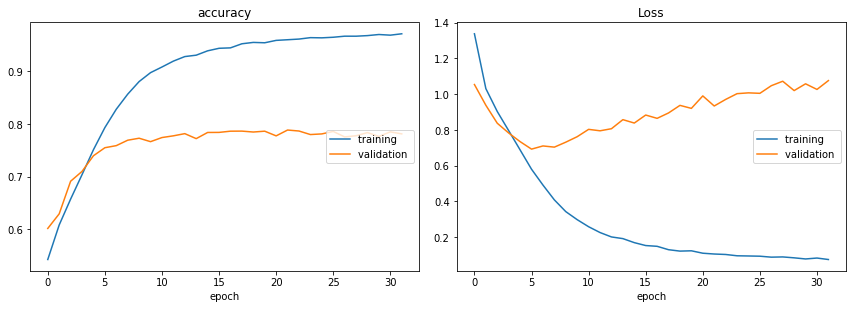

accuracy
	training         	 (min:    0.542, max:    0.971, cur:    0.971)
	validation       	 (min:    0.601, max:    0.788, cur:    0.781)
Loss
	training         	 (min:    0.074, max:    1.338, cur:    0.074)
	validation       	 (min:    0.692, max:    1.076, cur:    1.076)
4643/4643 [==============================] - 62s 13ms/step - loss: 0.0737 - accuracy: 0.9709 - val_loss: 1.0757 - val_accuracy: 0.7809


In [40]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [41]:
# save model
fname = 'final2 md gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [59]:
loss, acc = model.evaluate(validation_dataset, steps = len(y6test))
loss, acc

NameError: name 'model' is not defined

In [61]:
# testing duration
import time
def loadmodel(fname):
    model_file = 'Models/' + fname + '.json'
    w_file = 'Models/' + fname + '.h5'
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_md = model_from_json(loaded_model_json)
    model_md.load_weights(w_file)
    return model_md

In [65]:
mod_md = loadmodel('final2 md gd td2d')
validation_dataset = data_generator_pred(x6test, y6test)
t = time.time()
p = [np.squeeze(mod_md.predict(next(validation_dataset))) for i in range(len(y6test))]
time.time() - t

66.2660698890686

In [76]:
from tqdm import tqdm

In [77]:
mod_md = loadmodel('final2 md gd td2d')
validation_dataset = data_generator_pred(x6test, y6test)
elapsed_md = []
for i in tqdm(range(50),position=0):
    t = time.time()
    p = [np.squeeze(mod_md.predict(next(validation_dataset))) for i in range(len(y6test))]
    elapsed_md.append(time.time() - t)
np.mean(elapsed_md)

100%|██████████| 50/50 [51:08<00:00, 61.37s/it]


61.36595076084137

### RD

In [43]:
def tdcnn3d_bilstm_seq(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 4, 1)))(x)
        x = TimeDistributed(Flatten())(x)
#         x = Reshape(target_shape = (-1, 64*8*8*5))(x)
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [44]:
def tdcnn2d_bilstm_seq_vid(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)

        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Flatten())(x)

        x = Reshape(target_shape = (-1,32*16*16*5))(x)
#         x = Dropout(0.5)(x)
#         x = Bidirectional(LSTM(8, dropout=0.5, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
#         x = Dropout(0.5)(x)
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [45]:
# model = tdcnn3d_bilstm_seq(input_shape_vid)
model = tdcnn2d_bilstm_seq_vid(input_shape11)

In [46]:
train_dataset = data_generator(x12train, y6train) # x10train
validation_dataset = data_generator(x12test, y6test) # x10test

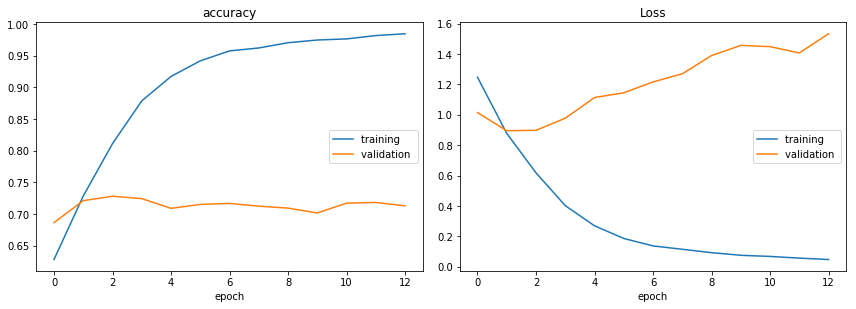

accuracy
	training         	 (min:    0.542, max:    0.984, cur:    0.984)
	validation       	 (min:    0.601, max:    0.788, cur:    0.713)
Loss
	training         	 (min:    0.048, max:    1.338, cur:    0.048)
	validation       	 (min:    0.692, max:    1.533, cur:    1.533)
4643/4643 [==============================] - 72s 16ms/step - loss: 0.0477 - accuracy: 0.9844 - val_loss: 1.5331 - val_accuracy: 0.7127


In [47]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [48]:
# save model
fname = 'final2 rd gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [49]:
loss, acc = model.evaluate(validation_dataset, steps = len(y6test))
loss, acc # 56.9

1164/1164 [==============================] - 8s 7ms/step - loss: 0.8979 - accuracy: 0.7279


(0.8979025483131409, 0.7278772592544556)

In [68]:
x10train[0].shape

(16, 5, 128, 128, 3)

In [35]:
def loadmodel(fname):
    model_file = 'Models/' + fname + '.json'
    w_file = 'Models/' + fname + '.h5'
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_md = model_from_json(loaded_model_json)
    model_md.load_weights(w_file)
    return model_md

In [37]:
import time

In [40]:
mod_rd = loadmodel('final2 rd gd td3d')
validation_dataset = data_generator_pred(x10test, y6test)
elapsed_rd = []
for i in range(1):
    t = time.time()
    p = [np.squeeze(mod_rd.predict(next(validation_dataset))) for i in range(len(y6test))]
    elapsed_rd.append(time.time() - t)
np.mean(elapsed_rd)

69.34711074829102

### RA

In [50]:
model = tdcnn2d_bilstm_seq_vid(input_shape11)

In [51]:
train_dataset = data_generator(x13train, y6train)
validation_dataset = data_generator(x13test, y6test)

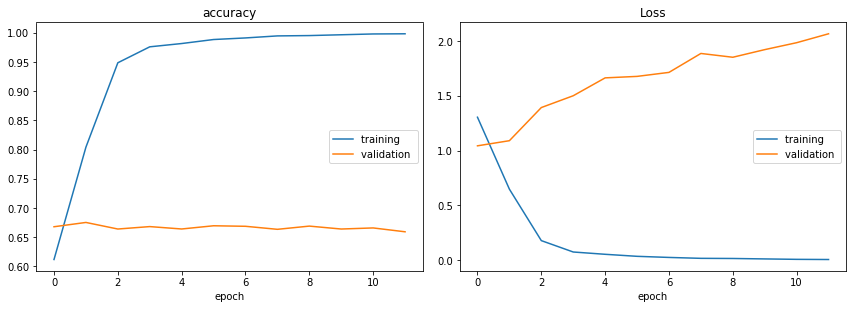

accuracy
	training         	 (min:    0.542, max:    0.998, cur:    0.998)
	validation       	 (min:    0.601, max:    0.788, cur:    0.659)
Loss
	training         	 (min:    0.006, max:    1.338, cur:    0.006)
	validation       	 (min:    0.692, max:    2.066, cur:    2.066)
4643/4643 [==============================] - 73s 16ms/step - loss: 0.0057 - accuracy: 0.9981 - val_loss: 2.0656 - val_accuracy: 0.6593


In [52]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [53]:
# save model
fname = 'final2 ra gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [54]:
loss, acc = model.evaluate(validation_dataset, steps = len(y6test))
loss, acc

1164/1164 [==============================] - 8s 7ms/step - loss: 1.0900 - accuracy: 0.6753


(1.0899542570114136, 0.6752557754516602)

In [39]:
mod_ra = loadmodel('final2 rd gd td3d')
validation_dataset = data_generator_pred(x11test, y6test)
elapsed_ra = []
for i in range(1):
    t = time.time()
    p = [np.squeeze(mod_ra.predict(next(validation_dataset))) for i in range(len(y6test))]
    elapsed_ra.append(time.time() - t)
np.mean(elapsed_ra)

67.83801102638245

### Fusion

In [55]:
def data_generator_multi(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
#             asldaily = labels[1][offset:offset+batch_size]
#             twohand = labels[2][offset:offset+batch_size]
#             major = labels[3][offset:offset+batch_size]
#             move = labels[4][offset:offset+batch_size]
#             stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
#             y_train2 = []
#             y_train3 = []
#             y_train4 = []
#             y_train5 = []
#             y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(label[i])
#                 y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train2.append(asldaily[i])
#                 y_train3.append(twohand[i])
#                 y_train4.append(major[i])
#                 y_train5.append(move[i])
#                 y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
#             y_train2 = np.array(y_train2)
#             y_train3 = np.array(y_train3)
#             y_train4 = np.array(y_train4)
#             y_train5 = np.array(y_train5)
#             y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3], y_train

In [56]:
train_dataset = data_generator_multi([x12train, x13train, x6train], [y6train])
validation_dataset = data_generator_multi([x12test, x13test, x6test], [y6test])

In [57]:
fname = 'final2 md gd td2d'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json)
model_md.load_weights(w_file)

In [58]:
fname = 'final2 rd gd td2d'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_rd = model_from_json(loaded_model_json)
model_rd.load_weights(w_file)

In [59]:
fname = 'final2 ra gd td2d'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ra = model_from_json(loaded_model_json)
model_ra.load_weights(w_file)

In [60]:
model_rd.layers[2].name

'time_distributed_10'

In [61]:
for layer in model_rd.layers:
    layer._name = layer.name+'_rd'

In [62]:
merged_layers = concatenate([model_rd.layers[-2].output,model_ra.layers[-2].output,model_md.layers[-2].output])
out1 = Dense(num_class,activation='softmax')(merged_layers)
model = keras.Model(inputs = [model_rd.input,model_ra.input,model_md.input],outputs = out1)#, out2, out3])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])

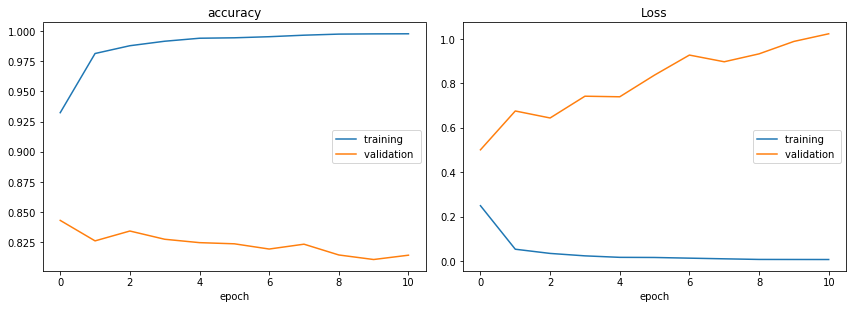

accuracy
	training         	 (min:    0.542, max:    0.998, cur:    0.998)
	validation       	 (min:    0.601, max:    0.843, cur:    0.814)
Loss
	training         	 (min:    0.006, max:    1.338, cur:    0.006)
	validation       	 (min:    0.501, max:    2.066, cur:    1.024)
4643/4643 [==============================] - 154s 33ms/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 1.0236 - val_accuracy: 0.8141


In [63]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [64]:
# save model
fname = 'final2 multi gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [65]:
loss, acc = model.evaluate(validation_dataset, steps = len(y6test))
loss, acc

1164/1164 [==============================] - 16s 14ms/step - loss: 0.5006 - accuracy: 0.8430


(0.5005859136581421, 0.8429667353630066)

In [66]:
# def multi_mod():
#     with tf.device('/gpu:2'):
        
#         inputlayer1 = Input(shape = input_shape_vid)
#         y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer1)
#         y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
#         y = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
#         y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
#         y = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
#         y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
#         y = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
#         y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
# #         y = TimeDistributed(Flatten())(y)
#         y = Reshape(target_shape = (-1, 64*4*4*5))(y)
#         y = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(y)
        
#         inputlayer2 = Input(shape = input_shape_vid)
#         z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer2)
#         z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
#         z = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
#         z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
#         z = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
#         z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
#         z = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
#         z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
# #         z = TimeDistributed(Flatten())(z)
#         z = Reshape(target_shape = (-1, 64*4*4*5))(z)
#         z = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(z)
        
#         inputlayer3 = Input(shape = input_shape11)
#         x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
# #         x = TimeDistributed(Flatten())(x)
#         x = Reshape(target_shape = (-1, 64*8*8))(x)
#         x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
        
#         cat = concatenate([y,z,x])
#         out = TimeDistributed(Dense(num_class,activation='softmax'))(cat)
        
#         model = keras.Model(inputs = [inputlayer1,inputlayer2,inputlayer3], outputs = [out])#, out2, out3])
#         opt = Adam(lr=1e-3, decay=1e-3 / 200)
#         model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        
#         return model 

In [67]:
# model = multi_mod()

In [68]:
# history = model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     batch_size = 1,
#     epochs=100,
#     steps_per_epoch = len(y6train), validation_steps = len(y6test),
#     callbacks=[early_stopping, PlotLossesKerasTF()],
#     verbose = 1
# )

In [69]:
# # save model
# fname = 'final2 multi gd'
# MODEL_FILE = 'Models/' + fname + '.json' # save path
# WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

# model_json = model.to_json()
# with open(MODEL_FILE, "w") as json_file:
#     json_file.write(model_json)
# model.save_weights(WEIGHT_FILE)

In [70]:
# loss, acc = model.evaluate(validation_dataset, steps = len(y6test))
# loss, acc

# CTC

In [29]:
y_int_train = np.array([np.argmax(y,-1) for y in y6train])
y_int_test = np.array([np.argmax(y,-1) for y in y6test])

In [30]:
y_asldaily_tr = [] # 0: daily, 1: asl
y_twohanded_tr = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_tr = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_tr = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_tr = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

y_asldaily_ts = [] # 0: daily, 1: asl
y_twohanded_ts = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_ts = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_ts = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_ts = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

## asl daily
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_tr.append(to_categorical(yx,2))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_ts.append(to_categorical(yx,2))
    
## two hand
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_tr.append(to_categorical(yx,3))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_ts.append(to_categorical(yx,3))

## hand loc
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] == 4:
            yx[j] = 1
        elif y_int_train[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_train[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_tr.append(to_categorical(yx,5))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] == 4:
            yx[j] = 1
        elif y_int_test[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_test[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_ts.append(to_categorical(yx,5))

## movement type
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_train[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_train[i][j] == 13:
            yx[j] = 3
        elif y_int_train[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_tr.append(to_categorical(yx,6))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_test[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_test[i][j] == 13:
            yx[j] = 3
        elif y_int_test[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_ts.append(to_categorical(yx,6))
    
## # of strokes
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_train[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_tr.append(to_categorical(yx,4))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_test[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_ts.append(to_categorical(yx,4))

In [31]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [32]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y6train]
ctc_ts3 = [num_to_ch(y) for y in y6test]
print(ctc_tr3[0])
# ctc_tr1 = [num_to_ch(y) for y in y10train]
# ctc_ts1 = [num_to_ch(y) for y in y10test]
# print(ctc_tr1[0])

ABBBBBBBBBBBBBBB


In [33]:
# convert detected labels
ctc_tr4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y6train]
ctc_ts4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y6test]
# ctc_tr4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y6train]
# ctc_ts4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y6test]
print(ctc_tr4[0])
# ctc_tr2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y10train]
# ctc_ts2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y10test]
# # ctc_tr2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y10train]
# # ctc_ts2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y10test]
# print(ctc_tr2[0])

BBBBBBBBBBBBBBBB


In [34]:
characters3 = set(char for label in ctc_tr3 for char in label)
print("Number of unique characters: ", len(characters3))
print("Characters present: ", sorted(characters3))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']


In [35]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True)

In [78]:
def data_generator_multi_md(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
#             yield [X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
            yield [X_train3, y_train], y_train

In [79]:
def data_generator_multi_nolabel_md(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train3]

In [303]:
train_dataset = data_generator_multi_md([x12train, x13train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_md([x12test, x13test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_md([x12test, x13test, x6test])

In [36]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred          

In [305]:
def ctc_md3():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
# #         x = TimeDistributed(Flatten())(x)
        
#         x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
# #         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
# #         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
# #         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         new_shape = (-1, 64*4*4//2) # 2 --> 13, 4 --> 17, 8 --> 23
        
        new_shape = (-1, (128//2**3) *64)
#         new_shape = (-1, 64*8*8) ## keeping time dim long increases the training time
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt)
        
        return model

In [306]:
model = ctc_md3()

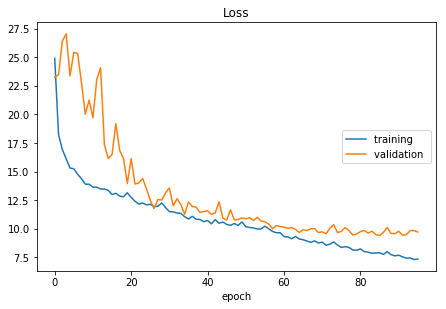

Loss
	training         	 (min:    0.006, max:   51.060, cur:    7.354)
	validation       	 (min:    0.501, max:   28.838, cur:    9.709)
4643/4643 [==============================] - 85s 18ms/step - loss: 7.3536 - val_loss: 9.7093


In [307]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [308]:
# save model
fname = 'final2 ctc md gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [309]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [310]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x6test))]

In [311]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

HHHHHHHHA


In [312]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCC | CCCCCCCCCC :Original
3. Predicted: HHHHHHHHA | AKKKKKKK :Original
4. Predicted: KKKKKA | KKKKAA :Original
5. Predicted: ALLLLLLLLLLAA | AALLLLLLLLLLAA :Original
6. Predicted: AMMMMMMMMMMMAAA | AMMMMMMMMMMAA :Original
7. Predicted: AADDDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBB | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCC | CCCCCCCCC :Original
10. Predicted: EEEEEEEEEEEEE | AEEEEEEEEEEAA :Original
11. Predicted: FFFFFFFFFFAA | AFFFFFFFFFFFAA :Original
12. Predicted: PPPPPPPPPPP | GGGGGGGGGGGGA :Original
13. Predicted: AAADDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBBBBBBCCCCCCC | BBBBBBBBBCCCCCCCC :Original
15. Predicted: KKKKEEEEEA | KKKKKKKKKKAA :Original
16. Predicted: ALLLLLLLLLLAAA | ALLLLLLLLLLLAAA :Original
17. Predicted: AABBBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBB | BBBBBBBBBBBB :Original
19. Predicted: CCCCCCCC | CCCCCCCCA :Original
2

In [313]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [314]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

80.58419243986255

In [315]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

65.93989769820972

### RD

In [329]:
def ctc_rd3():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
#         cnv1 = TimeDistributed(Flatten())(x)
        new_shape = (-1, (128//2**3) *64*5)
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt)
        
        return model

In [330]:
def ctc_rd33():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="rd")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        new_shape = (-1, 32*8*8*5//2)
        
#         new_shape = (-1, (128//2**3) *64*5)
#         new_shape = (-1, 64*8*8) ## keeping time dim long increases the training time
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
        cnv1 = Bidirectional(LSTM(32, dropout=0.5, return_sequences=True))(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc], 
                           name="ctc_model")
        opt = Adam(lr=2e-4, decay=1e-3 / 200)
        model.compile(optimizer=opt)
        
        return model

In [331]:
model = ctc_rd3()
# model.summary()

In [332]:
train_dataset = data_generator_multi_md([x13train, x6train, x10train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_md([x13test, x6test, x10test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_md([x13test, x6test, x10test])

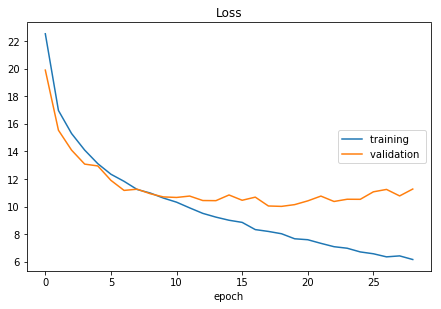

Loss
	training         	 (min:    0.006, max:   51.060, cur:    6.162)
	validation       	 (min:    0.501, max:   28.838, cur:   11.268)
4643/4643 [==============================] - 232s 50ms/step - loss: 6.1617 - val_loss: 11.2681


In [333]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x12train), validation_steps = len(x12test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [334]:
# save model
fname = 'final2 ctc rd gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [335]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="rd").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [336]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(y6test))]

In [337]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AHHHHHKKKKKA


In [338]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: ABBBBBBBBBBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCCCCC | CCCCCCCCCC :Original
3. Predicted: AHHHHHKKKKKA | AKKKKKKK :Original
4. Predicted: KGGAA | KKKKAA :Original
5. Predicted: AAAALLLLLLLLLLLAAA | AALLLLLLLLLLAA :Original
6. Predicted: AMMMMMMMMMMAAA | AMMMMMMMMMMAA :Original
7. Predicted: ADDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBB | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCCCCC | CCCCCCCCC :Original
10. Predicted: AEEEEEEEEEEEAA | AEEEEEEEEEEAA :Original
11. Predicted: AFFFFFFFFFFFAAAAA | AFFFFFFFFFFFAA :Original
12. Predicted: AGGGGGGGGGGGAA | GGGGGGGGGGGGA :Original
13. Predicted: AADDDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBBBBBBBBBBBCCC | BBBBBBBBBCCCCCCCC :Original
15. Predicted: IIRIIIIIIR | KKKKKKKKKKAA :Original
16. Predicted: AFFFFFFFFFFFAAAAAAA | ALLLLLLLLLLLAAA :Original
17. Predicted: BBBBBBBBBBBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
19. 

In [339]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [340]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 70 without //8

78.43642611683849

In [341]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts4[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
# cmp = [mode_orig[i] == mode_pred[i] for i in range(len(ctc_ts4))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # was 71 without //8

78.81074168797953

### RA

In [107]:
def ctc_ra3():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="ra")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        new_shape = (-1,(128//2**3)*64*5)
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt)
        
        return model

In [108]:
def ctc_ra33():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="ra")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        new_shape = (-1, 64*8*8*5//2)
        
#         new_shape = (-1, (128//2**3) *64*5)
#         new_shape = (-1, 64*8*8) ## keeping time dim long increases the training time
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc], 
                           name="ctc_model")
        opt = Adam(lr=2e-4, decay=1e-3 / 200)
        model.compile(optimizer=opt)
        
        return model

In [261]:
model = ctc_ra3()

In [262]:
train_dataset = data_generator_multi_md([x12train, x6train, x11train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_md([x12test, x6test, x11test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_md([x12test, x6test, x11test])

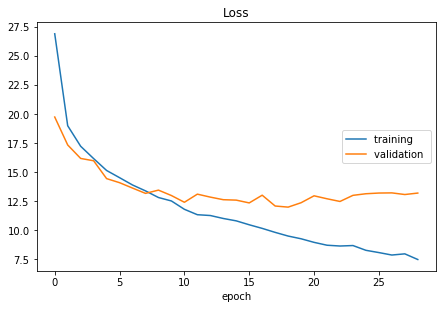

Loss
	training         	 (min:    0.006, max:   51.060, cur:    7.457)
	validation       	 (min:    0.501, max:   27.300, cur:   13.177)
4643/4643 [==============================] - 231s 50ms/step - loss: 7.4566 - val_loss: 13.1770


In [263]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [264]:
# save model
fname = 'final2 ctc ra gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [265]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="ra").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [266]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(y6test))]

In [267]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AJJJJJ


In [269]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AABBBBBBBBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCC | CCCCCCCCCC :Original
3. Predicted: AJJJJJ | AKKKKKKK :Original
4. Predicted: HHHHNAA | KKKKAA :Original
5. Predicted: AALLILIIIIIAAAA | AALLLLLLLLLLAA :Original
6. Predicted: AMMMMMMMMMMAA | AMMMMMMMMMMAA :Original
7. Predicted: AADDDDDDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBB | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCCC | CCCCCCCCC :Original
10. Predicted: AEEEEEEEEEGAAA | AEEEEEEEEEEAA :Original
11. Predicted: AFFFFFFFFFAAAA | AFFFFFFFFFFFAA :Original
12. Predicted: AJJJJJJJJJAAAA | GGGGGGGGGGGGA :Original
13. Predicted: ADDDDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBBBBBBBBCCCCCC | BBBBBBBBBCCCCCCCC :Original
15. Predicted: KKKKKKKKKKAA | KKKKKKKKKKAA :Original
16. Predicted: AFFFFLFFFFFFAAAA | ALLLLLLLLLLLAAA :Original
17. Predicted: BBBBBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBBB | BBBBBBBBBBBB :Original
19. Predicted: CCCCCCCCC |

In [270]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [271]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

71.30584192439862

In [274]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

60.54347826086956

### Fusion

In [342]:
fname = 'final2 ctc md gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_md.load_weights(w_file)

In [343]:
fname = 'final2 ctc rd gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_rd = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_rd.load_weights(w_file)

In [344]:
fname = 'final2 ctc ra gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ra = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_ra.load_weights(w_file)

In [345]:
def data_generator_multi_ctcx(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
#             yield [X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
            yield [X_train1, X_train2, X_train3, y_train], y_train

In [346]:
def data_generator_multi_nolabel_ctcx(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [347]:
train_dataset = data_generator_multi_ctcx([x10train, x11train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_ctcx([x10test, x11test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_ctcx([x10test, x11test, x6test])

In [348]:
def multi_ctc_mod():
    merged_layers = concatenate([model_rd.layers[-4].output,model_ra.layers[-4].output,model_md.layers[-4].output])
    x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(merged_layers)
    labels = Input(name="label", shape=(None,))#, dtype="float32")
    out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
    opt = Adam(lr=1e-3, decay=1e-3 / 200)  
    model = keras.Model(inputs = [model_rd.get_layer('rd').input, model_ra.get_layer('ra').input, model_md.get_layer('image').input, labels], 
                                outputs = out_ctc, 
                               name="ctc_model")
    model.compile(optimizer=opt)
    return model

In [350]:
model = multi_ctc_mod()
# model.summary(line_length=150)

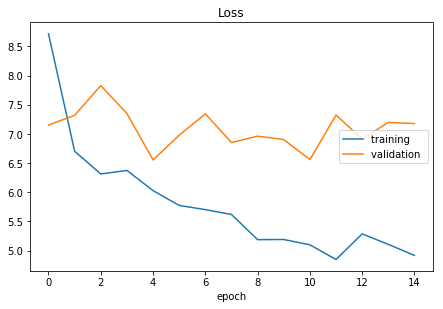

Loss
	training         	 (min:    0.006, max:   51.060, cur:    4.919)
	validation       	 (min:    0.501, max:   28.838, cur:    7.177)
4643/4643 [==============================] - 485s 104ms/step - loss: 4.9193 - val_loss: 7.1771


In [351]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [352]:
# save model
fname = 'final2 multi ctc gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [353]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model.get_layer(name="rd").input, model.get_layer(name="ra").input, model.get_layer(name="image").input], model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [354]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(y6test))]

In [355]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AKKKKKKA


In [356]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCCCCCCCC | CCCCCCCCCC :Original
3. Predicted: AKKKKKKA | AKKKKKKK :Original
4. Predicted: KKNAAAAA | KKKKAA :Original
5. Predicted: AAAALLLLLLLLLLLAAAA | AALLLLLLLLLLAA :Original
6. Predicted: AMMMMMMMMMMMAA | AMMMMMMMMMMAA :Original
7. Predicted: AADDDDDDDDDDDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCCCCC | CCCCCCCCC :Original
10. Predicted: EEEEEEEEEEQAAA | AEEEEEEEEEEAA :Original
11. Predicted: AFFFFFFFFFFFAAAAAAA | AFFFFFFFFFFFAA :Original
12. Predicted: AGGGGGGGGGGGGAAAA | GGGGGGGGGGGGA :Original
13. Predicted: ADDDDDDDDDDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBCCCCCCCC :Original
15. Predicted: KKKKKKKKKKKKKA | KKKKKKKKKKAA :Original
16. Predicted: ALLLLLLLLLLFAAAAAAAA | ALLLLLLLLLLLAAA :Original
17. Predicted: BBBBBBBBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBBBBB | BB

In [357]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [358]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

87.54295532646049

In [359]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

72.79411764705883

# CTC + MTL

In [37]:
def data_generator_mtl(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
#             yield [X_train3, y_train], y_train

In [38]:
def data_generator_mtl_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train3]

### mD

In [363]:
train_dataset = data_generator_mtl([x12train, x13train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x12test, x13test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x12test, x13test, x6test])

In [364]:
def ctc_md_mtl():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         new_shape = (-1, 64*8*8//2)
        
        new_shape = (-1, (128//2**3) *64)
#         new_shape = (-1, 16*16*64//2)
#         new_shape = (-1, 16*16*16//8) ## keeping time dim long increases the training time
        
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
#         cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(cnv1)
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=2e-4, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [365]:
model = ctc_md_mtl()

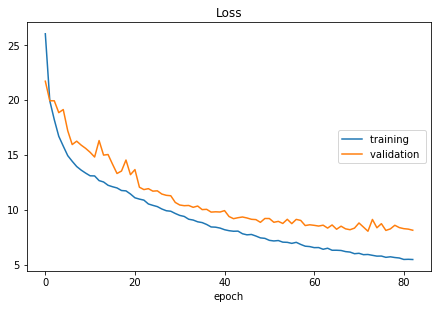

Loss
	training         	 (min:    0.006, max:   51.060, cur:    5.475)
	validation       	 (min:    0.501, max:   28.838, cur:    8.137)
4643/4643 [==============================] - 84s 18ms/step - loss: 5.4748 - val_loss: 8.1373


In [366]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [367]:
# save model
fname = 'final2 ctc mtl md gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [368]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [369]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x6test))]

In [370]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

KKHHHHAA


In [371]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCCCCA | CCCCCCCCCC :Original
3. Predicted: KKHHHHAA | AKKKKKKK :Original
4. Predicted: AKAAAA | KKKKAA :Original
5. Predicted: AALLLLLLLLLLAA | AALLLLLLLLLLAA :Original
6. Predicted: MMMMMMMMMMMMAA | AMMMMMMMMMMAA :Original
7. Predicted: ADDDDDDDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBA | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCCCCCCCA | CCCCCCCCC :Original
10. Predicted: EEEEEEEEEEEEAA | AEEEEEEEEEEAA :Original
11. Predicted: AFFFFFFFFFFAAA | AFFFFFFFFFFFAA :Original
12. Predicted: APPJJJJJJJA | GGGGGGGGGGGGA :Original
13. Predicted: ADDDDDDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBCCCCCCCCCCCCCCC | BBBBBBBBBCCCCCCCC :Original
15. Predicted: KKKKKHHKAAA | KKKKKKKKKKAA :Original
16. Predicted: ALLLLLLLLLLLAAAA | ALLLLLLLLLLLAAA :Original
17. Predicted: AAABBBBBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
19. Pr

In [372]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [373]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

83.59106529209622

In [374]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

68.71483375959079

### RD

In [390]:
def ctc_rd_mtl():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        
        new_shape = (-1, (128//2**3)*64*5)
#         new_shape = (-1, 8*8*64)
#         new_shape = (-1, (64//2**3)*5*8)
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(cnv1)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [395]:
def ctc_rd_mtl2():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="rd")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        new_shape = (-1, 64*8*8*5//2)
        
#         new_shape = (-1, (128//2**3) *64*5)
#         new_shape = (-1, 16*16*64//2)
#         new_shape = (-1, 16*16*16//8) ## keeping time dim long increases the training time
        
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
#         cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=2e-4, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [396]:
train_dataset = data_generator_mtl([x6train, x11train, x10train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x6test, x11test, x10test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x6test, x11test, x10test])

In [397]:
model = ctc_rd_mtl()

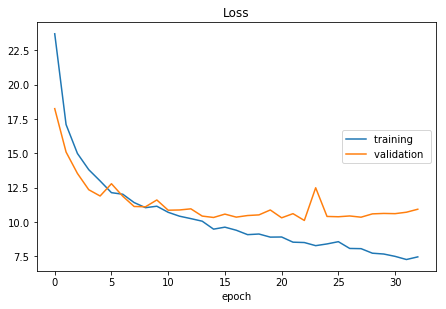

Loss
	training         	 (min:    0.006, max:   51.060, cur:    7.467)
	validation       	 (min:    0.501, max:   28.838, cur:   10.935)
4643/4643 [==============================] - 232s 50ms/step - loss: 7.4673 - val_loss: 10.9352


In [398]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [399]:
# save model
fname = 'final2 ctc mtl rd gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [400]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="rd").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [401]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x10test))]

In [402]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

KKKKKKA


In [403]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: ABBBBBBBBBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCCCCC | CCCCCCCCCC :Original
3. Predicted: KKKKKKA | AKKKKKKK :Original
4. Predicted: KAAA | KKKKAA :Original
5. Predicted: AAALLLLLLFFF | AALLLLLLLLLLAA :Original
6. Predicted: AMMMMMMMMMMAA | AMMMMMMMMMMAA :Original
7. Predicted: AADDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCC | CCCCCCCCC :Original
10. Predicted: AEEEEEEEEEEEA | AEEEEEEEEEEAA :Original
11. Predicted: AFFFFFFFFFFAAAAAA | AFFFFFFFFFFFAA :Original
12. Predicted: AAGGGGGGGGGGGA | GGGGGGGGGGGGA :Original
13. Predicted: AADDDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBBBBBBBBBCBBBCCC | BBBBBBBBBCCCCCCCC :Original
15. Predicted: KKKKKKKKKKAA | KKKKKKKKKKAA :Original
16. Predicted: AFFFFFFFFFFFFAAAAAAAAA | ALLLLLLLLLLLAAA :Original
17. Predicted: BBBBBBBBBBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
19. P

In [404]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [405]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

78.6082474226804

In [406]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

65.39641943734016

### RA

In [39]:
train_dataset = data_generator_mtl([x6train, x10train, x11train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x6test, x10test, x11test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x6test, x10test, x11test])

In [42]:
def ctc_ra_mtl():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="ra")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        
        new_shape = (-1, (128//2**3)*64*5)
#         new_shape = (-1, 8*8*64)
#         new_shape = (-1, (64//2**3)*5*8)
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(cnv1)
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [41]:
def ctc_ra_mtl2():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="ra")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        new_shape = (-1, 64*8*8*5//2)
        
#         new_shape = (-1, (128//2**3) *64*5)
#         new_shape = (-1, 16*16*64//2)
#         new_shape = (-1, 16*16*16//8) ## keeping time dim long increases the training time
        
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
#         cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=2e-4, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.1,0.1,0.1,0.1,0.1])
        
        return model

In [466]:
model = ctc_ra_mtl()

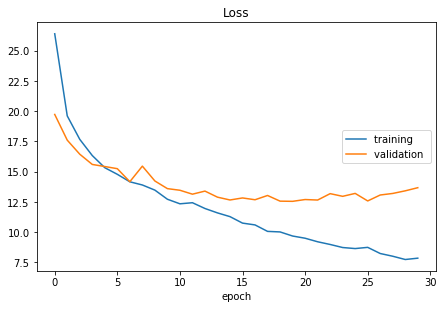

Loss
	training         	 (min:    0.006, max:   51.060, cur:    7.846)
	validation       	 (min:    0.501, max:   28.838, cur:   13.672)
4643/4643 [==============================] - 232s 50ms/step - loss: 7.8457 - val_loss: 13.6719


In [467]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x11train), validation_steps = len(x11test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [468]:
# save model
fname = 'final2 ctc mtl ra gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [469]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="ra").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [470]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

In [471]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

ARKKEEKE


In [472]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: ABBBBBBBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCCCCCC | CCCCCCCCCC :Original
3. Predicted: ARKKEEKE | AKKKKKKK :Original
4. Predicted: HKAAA | KKKKAA :Original
5. Predicted: AAOOOOOLLLLAA | AALLLLLLLLLLAA :Original
6. Predicted: AAMMMMMMMMMMAAA | AMMMMMMMMMMAA :Original
7. Predicted: ADDDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCCC | CCCCCCCCC :Original
10. Predicted: EEEEEEEEEEEEAA | AEEEEEEEEEEAA :Original
11. Predicted: ALLLLLLLLLLAAAAAAAA | AFFFFFFFFFFFAA :Original
12. Predicted: AGGGGGGGGFAAAA | GGGGGGGGGGGGA :Original
13. Predicted: AADDDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBBBBBBBBBBBBBBBBCC | BBBBBBBBBCCCCCCCC :Original
15. Predicted: QKKKKKKKKAAAAA | KKKKKKKKKKAA :Original
16. Predicted: AFFFFFFLLFFFFLAAAAAAA | ALLLLLLLLLLLAAA :Original
17. Predicted: ABBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
19. Predi

In [473]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [474]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

70.7044673539519

In [475]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

59.68030690537084

# ra best model search

In [43]:
from collections import Counter
acc_ls = []
best = 71.3
fname = 'final2 ctc mtl ra gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path
while True:
    model = ctc_ra_mtl()
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        batch_size = 1,
        epochs=100,
        steps_per_epoch = len(x11train), validation_steps = len(x11test),
        callbacks=[early_stopping],
        verbose = 0
    )
    prediction_model = keras.models.Model(
        model.get_layer(name="ra").input, model.get_layer(name="dense2").output
    )
    pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

    pred_labels = []
    for p in pred:
        label = ''
        for num in p:
            if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
                continue
            label = label + chr(ord('@')+num)
        pred_labels.append(label)
    pred_labels = np.array(pred_labels)  
    
    mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
    mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]
    cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
    trues = np.sum(cmp)
    acc = trues/len(cmp)*100
    acc_ls.append(acc)
    print('Acc: '+str(acc))
    if acc > best:
        best = acc

        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
        print('New model with acc of '+str(acc)+' is saved!')

Acc: 69.15807560137456
Acc: 70.1890034364261
Acc: 70.1890034364261
Acc: 69.3298969072165
Acc: 69.7594501718213
Acc: 70.27491408934708
Acc: 68.55670103092784


Acc: 70.36082474226805
Acc: 68.12714776632302
Acc: 69.7594501718213
Acc: 71.3917525773196
New model with acc of 71.3917525773196 is saved!
Acc: 67.69759450171821
Acc: 68.72852233676976
Acc: 67.61168384879726


Acc: 71.30584192439862
Acc: 70.7044673539519


KeyboardInterrupt: 

### Fusion

In [476]:
def data_generator_mtl_multi(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
#             yield [X_train3, y_train], y_train

In [477]:
def data_generator_mtl_nolabel_multi(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [478]:
train_dataset = data_generator_mtl_multi([x10train, x11train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl_multi([x10test, x11test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel_multi([x10test, x11test, x6test])

In [479]:
fname = 'final2 ctc mtl md gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_md.load_weights(w_file)

In [480]:
fname = 'final2 ctc mtl rd gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_rd = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_rd.load_weights(w_file)

In [481]:
fname = 'final2 ctc mtl ra gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ra = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_ra.load_weights(w_file)

In [495]:
def multi_ctc_mtl_mod():
    labels = Input(name="label", shape=(None,))#, dtype="float32")
    asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
    hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
    loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
    mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
    stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
    
    merged_layers = concatenate([model_rd.layers[-10].output,model_ra.layers[-10].output,model_md.layers[-10].output])
    aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(merged_layers)
#     aux_pool = merged_layers
    
    x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(merged_layers)
    
    out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
    out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
    out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
    out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
    out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)

    out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
    opt = Adam(lr=2e-4, decay=1e-3 / 200)  
    model = keras.Model(inputs = [model_rd.get_layer('rd').input, model_ra.get_layer('ra').input, model_md.get_layer('image').input, labels], 
                                outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                               name="ctc_model")
    model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
    return model

In [498]:
def multi_ctc_mtl_mod_grid(w8,lr):
    labels = Input(name="label", shape=(None,))#, dtype="float32")
    asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
    hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
    loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
    mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
    stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
    
    merged_layers = concatenate([model_rd.layers[-10].output,model_ra.layers[-10].output,model_md.layers[-10].output])
    aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(merged_layers)
#     aux_pool = merged_layers
    
    x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(merged_layers)
    
    out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
    out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
    out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
    out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
    out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)

    out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
    opt = Adam(lr=lr, decay=1e-3 / 200)  
    model = keras.Model(inputs = [model_rd.get_layer('rd').input, model_ra.get_layer('ra').input, model_md.get_layer('image').input, labels], 
                                outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                               name="ctc_model")
    model.compile(optimizer=opt, loss_weights = [1,w8,w8,w8,w8,w8])
    return model

In [519]:
model = multi_ctc_mtl_mod()

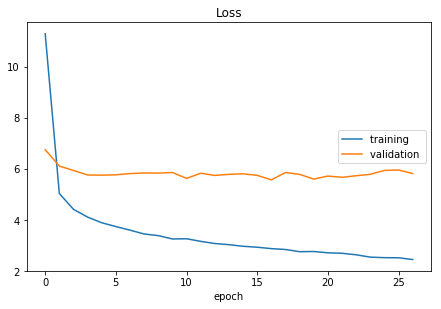

Loss
	training         	 (min:    0.006, max:  120.866, cur:    2.448)
	validation       	 (min:    0.501, max:  118.035, cur:    5.814)
4643/4643 [==============================] - 489s 105ms/step - loss: 2.4477 - val_loss: 5.8143


In [520]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [521]:
# # save model
# fname = 'final2 multi ctc mtl gd'
# MODEL_FILE = 'Models/' + fname + '.json' # save path
# WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

# model_json = model.to_json()
# with open(MODEL_FILE, "w") as json_file:
#     json_file.write(model_json)
# model.save_weights(WEIGHT_FILE)

In [522]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model.get_layer(name="rd").input, model.get_layer(name="ra").input, model.get_layer(name="image").input], model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [523]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

In [524]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AKKKKKKKKK


In [525]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AAABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCCCCCA | CCCCCCCCCC :Original
3. Predicted: AKKKKKKKKK | AKKKKKKK :Original
4. Predicted: KKKKAA | KKKKAA :Original
5. Predicted: AAALLLLLLLLLLLAAA | AALLLLLLLLLLAA :Original
6. Predicted: AMMMMMMMMMMMAAAA | AMMMMMMMMMMAA :Original
7. Predicted: AADDDDDDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCCCCA | CCCCCCCCC :Original
10. Predicted: EEEEEEEEEEEEAA | AEEEEEEEEEEAA :Original
11. Predicted: AFFFFFFFFFFFAAAAA | AFFFFFFFFFFFAA :Original
12. Predicted: GGGGGGGGGGGAAA | GGGGGGGGGGGGA :Original
13. Predicted: AAADDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBBBBBCCCCCCCC | BBBBBBBBBCCCCCCCC :Original
15. Predicted: KKKKKKKKKK | KKKKKKKKKKAA :Original
16. Predicted: ALLLLLLLLLLLLLLAAAAAAA | ALLLLLLLLLLLAAA :Original
17. Predicted: ABBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBBBBBBBBBBBBB |

In [526]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [527]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

92.0103092783505

In [528]:
# save model
if acc > 89.1:
    fname = 'final2 multi ctc mtl gd'
    MODEL_FILE = 'Models/' + fname + '.json' # save path
    WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

    model_json = model.to_json()
    with open(MODEL_FILE, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(WEIGHT_FILE)

## Grid

In [516]:
acc_best = 89.1
accs = []
lr = [1e-3,2e-4]
w8 = [0.1,0.2,0.3]
cntx = 1
for l in range(len(lr)):
    for w in range(len(w8)):
        model = multi_ctc_mtl_mod_grid(w,l)
        history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            batch_size = 1,
            epochs=100,
            steps_per_epoch = len(y6train), validation_steps = len(y6test),
            callbacks=[early_stopping],
            verbose = 0
        )
        prediction_model = keras.models.Model(
            [model.get_layer(name="rd").input, model.get_layer(name="ra").input, model.get_layer(name="image").input], model.get_layer(name="dense2").output
        )
        pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]
        pred_labels = []
        for p in pred:
            label = ''
            for num in p:
                if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
                    continue
                label = label + chr(ord('@')+num)
            pred_labels.append(label)
        pred_labels = np.array(pred_labels)  

        mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
        mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]
        cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
        trues = np.sum(cmp)
        acc = trues/len(cmp)*100
        accs.append(acc)
        
        print(str(cntx)+'. model: LR='+str(lr[l])+', W8='+str(w8[w])+', ACC='+str(acc))
        if acc > acc_best:
            acc_best = acc
            fname = 'final2 multi ctc mtl gd'
            MODEL_FILE = 'Models/' + fname + '.json' # save path
            WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

            model_json = model.to_json()
            with open(MODEL_FILE, "w") as json_file:
                json_file.write(model_json)
            model.save_weights(WEIGHT_FILE)
        cntx += 1    

KeyboardInterrupt: 

In [ ]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')